In [29]:
!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

In [30]:
import numpy as np

X = np.load('/kaggle/input/unber-1k/Visual_Features/Visual_Features/X_data.npy')
y = np.load('/kaggle/input/unber-1k/Visual_Features/Visual_Features/y_data.npy')

In [31]:
X.shape

(1118, 5, 224, 224, 3)

In [32]:
y.shape

(1118,)

In [33]:
X = X.reshape(-1, 224, 224, 3)
y = np.repeat(y, 5)

In [34]:
X.shape

(5590, 224, 224, 3)

In [35]:
y.shape

(5590,)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [37]:
from PIL import Image

def data_generator(X, y):
    for img, label in zip(X, y):
        img = np.squeeze(img)  # Remove extra dimensions if present
        img = Image.fromarray(np.uint8(img))  # Convert to PIL image
        yield {"image": img, "labels": label}

In [38]:
from datasets import Dataset

train_dataset = Dataset.from_generator(lambda: data_generator(X_train, y_train))
test_dataset = Dataset.from_generator(lambda: data_generator(X_test, y_test))
val_dataset = Dataset.from_generator(lambda: data_generator(X_val, y_val))

In [39]:
train_dataset

Dataset({
    features: ['image', 'labels'],
    num_rows: 4472
})

In [40]:
entry = train_dataset[4]
entry

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'labels': 3}

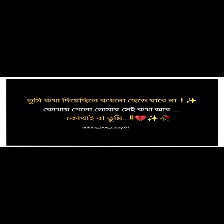

In [41]:
image = entry['image']
image

In [42]:
dataset = train_dataset

In [43]:
import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [44]:
from torchvision import transforms
from torch.utils.data import Dataset

# Define a custom dataset class
class ReelDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        label = item['labels']
        return self.transform(image), label

In [45]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation sets
train_loader = DataLoader(ReelDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(ReelDataset(val_dataset), batch_size=32, shuffle=False)
test_loader = DataLoader(ReelDataset(test_dataset), batch_size=32, shuffle=False)

In [46]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [47]:
num_classes = 4
model_ft = CLIPFineTuner(model, num_classes).to(device)

In [48]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

In [49]:
from tqdm import tqdm

# Number of epochs for training
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

Epoch 1/50, Loss: 1.2900: 100%|██████████| 140/140 [00:18<00:00,  7.49it/s]


Epoch [1/50], Loss: 1.2900
Validation Accuracy: 45.974955277280856%


Epoch 2/50, Loss: 1.1780: 100%|██████████| 140/140 [00:18<00:00,  7.57it/s]


Epoch [2/50], Loss: 1.1780
Validation Accuracy: 52.23613595706619%


Epoch 3/50, Loss: 1.1077: 100%|██████████| 140/140 [00:18<00:00,  7.42it/s]


Epoch [3/50], Loss: 1.1077
Validation Accuracy: 58.318425760286225%


Epoch 4/50, Loss: 1.0555: 100%|██████████| 140/140 [00:18<00:00,  7.46it/s]


Epoch [4/50], Loss: 1.0555
Validation Accuracy: 59.92844364937388%


Epoch 5/50, Loss: 1.0152: 100%|██████████| 140/140 [00:18<00:00,  7.56it/s]


Epoch [5/50], Loss: 1.0152
Validation Accuracy: 60.644007155635066%


Epoch 6/50, Loss: 0.9838: 100%|██████████| 140/140 [00:18<00:00,  7.52it/s]


Epoch [6/50], Loss: 0.9838
Validation Accuracy: 62.432915921288014%


Epoch 7/50, Loss: 0.9578: 100%|██████████| 140/140 [00:18<00:00,  7.51it/s]


Epoch [7/50], Loss: 0.9578
Validation Accuracy: 63.506261180679786%


Epoch 8/50, Loss: 0.9362: 100%|██████████| 140/140 [00:18<00:00,  7.55it/s]


Epoch [8/50], Loss: 0.9362
Validation Accuracy: 63.864042933810374%


Epoch 9/50, Loss: 0.9181: 100%|██████████| 140/140 [00:18<00:00,  7.49it/s]


Epoch [9/50], Loss: 0.9181
Validation Accuracy: 64.22182468694096%


Epoch 10/50, Loss: 0.9024: 100%|██████████| 140/140 [00:18<00:00,  7.37it/s]


Epoch [10/50], Loss: 0.9024
Validation Accuracy: 63.864042933810374%


Epoch 11/50, Loss: 0.8894: 100%|██████████| 140/140 [00:18<00:00,  7.40it/s]


Epoch [11/50], Loss: 0.8894
Validation Accuracy: 64.04293381037567%


Epoch 12/50, Loss: 0.8772: 100%|██████████| 140/140 [00:19<00:00,  7.32it/s]


Epoch [12/50], Loss: 0.8772
Validation Accuracy: 64.75849731663685%


Epoch 13/50, Loss: 0.8670: 100%|██████████| 140/140 [00:19<00:00,  7.35it/s]


Epoch [13/50], Loss: 0.8670
Validation Accuracy: 64.93738819320215%


Epoch 14/50, Loss: 0.8576: 100%|██████████| 140/140 [00:19<00:00,  7.37it/s]


Epoch [14/50], Loss: 0.8576
Validation Accuracy: 65.29516994633273%


Epoch 15/50, Loss: 0.8484: 100%|██████████| 140/140 [00:19<00:00,  7.31it/s]


Epoch [15/50], Loss: 0.8484
Validation Accuracy: 64.93738819320215%


Epoch 16/50, Loss: 0.8410: 100%|██████████| 140/140 [00:19<00:00,  7.36it/s]


Epoch [16/50], Loss: 0.8410
Validation Accuracy: 64.75849731663685%


Epoch 17/50, Loss: 0.8338: 100%|██████████| 140/140 [00:18<00:00,  7.43it/s]


Epoch [17/50], Loss: 0.8338
Validation Accuracy: 65.11627906976744%


Epoch 18/50, Loss: 0.8267: 100%|██████████| 140/140 [00:19<00:00,  7.31it/s]


Epoch [18/50], Loss: 0.8267
Validation Accuracy: 65.47406082289804%


Epoch 19/50, Loss: 0.8204: 100%|██████████| 140/140 [00:19<00:00,  7.31it/s]


Epoch [19/50], Loss: 0.8204
Validation Accuracy: 65.65295169946333%


Epoch 20/50, Loss: 0.8146: 100%|██████████| 140/140 [00:18<00:00,  7.43it/s]


Epoch [20/50], Loss: 0.8146
Validation Accuracy: 65.65295169946333%


Epoch 21/50, Loss: 0.8090: 100%|██████████| 140/140 [00:18<00:00,  7.46it/s]


Epoch [21/50], Loss: 0.8090
Validation Accuracy: 66.01073345259391%


Epoch 22/50, Loss: 0.8036: 100%|██████████| 140/140 [00:18<00:00,  7.41it/s]


Epoch [22/50], Loss: 0.8036
Validation Accuracy: 66.18962432915922%


Epoch 23/50, Loss: 0.7986: 100%|██████████| 140/140 [00:18<00:00,  7.56it/s]


Epoch [23/50], Loss: 0.7986
Validation Accuracy: 66.01073345259391%


Epoch 24/50, Loss: 0.7938: 100%|██████████| 140/140 [00:18<00:00,  7.51it/s]


Epoch [24/50], Loss: 0.7938
Validation Accuracy: 66.01073345259391%


Epoch 25/50, Loss: 0.7890: 100%|██████████| 140/140 [00:18<00:00,  7.53it/s]


Epoch [25/50], Loss: 0.7890
Validation Accuracy: 65.83184257602862%


Epoch 26/50, Loss: 0.7851: 100%|██████████| 140/140 [00:18<00:00,  7.55it/s]


Epoch [26/50], Loss: 0.7851
Validation Accuracy: 66.18962432915922%


Epoch 27/50, Loss: 0.7809: 100%|██████████| 140/140 [00:18<00:00,  7.51it/s]


Epoch [27/50], Loss: 0.7809
Validation Accuracy: 66.01073345259391%


Epoch 28/50, Loss: 0.7769: 100%|██████████| 140/140 [00:18<00:00,  7.51it/s]


Epoch [28/50], Loss: 0.7769
Validation Accuracy: 65.83184257602862%


Epoch 29/50, Loss: 0.7732: 100%|██████████| 140/140 [00:18<00:00,  7.57it/s]


Epoch [29/50], Loss: 0.7732
Validation Accuracy: 65.65295169946333%


Epoch 30/50, Loss: 0.7696: 100%|██████████| 140/140 [00:18<00:00,  7.51it/s]


Epoch [30/50], Loss: 0.7696
Validation Accuracy: 65.65295169946333%


Epoch 31/50, Loss: 0.7660: 100%|██████████| 140/140 [00:18<00:00,  7.50it/s]


Epoch [31/50], Loss: 0.7660
Validation Accuracy: 65.83184257602862%


Epoch 32/50, Loss: 0.7622: 100%|██████████| 140/140 [00:19<00:00,  7.31it/s]


Epoch [32/50], Loss: 0.7622
Validation Accuracy: 65.83184257602862%


Epoch 33/50, Loss: 0.7590: 100%|██████████| 140/140 [00:19<00:00,  7.35it/s]


Epoch [33/50], Loss: 0.7590
Validation Accuracy: 66.5474060822898%


Epoch 34/50, Loss: 0.7564: 100%|██████████| 140/140 [00:19<00:00,  7.36it/s]


Epoch [34/50], Loss: 0.7564
Validation Accuracy: 66.18962432915922%


Epoch 35/50, Loss: 0.7528: 100%|██████████| 140/140 [00:18<00:00,  7.44it/s]


Epoch [35/50], Loss: 0.7528
Validation Accuracy: 66.3685152057245%


Epoch 36/50, Loss: 0.7498: 100%|██████████| 140/140 [00:18<00:00,  7.43it/s]


Epoch [36/50], Loss: 0.7498
Validation Accuracy: 66.5474060822898%


Epoch 37/50, Loss: 0.7468: 100%|██████████| 140/140 [00:18<00:00,  7.43it/s]


Epoch [37/50], Loss: 0.7468
Validation Accuracy: 66.18962432915922%


Epoch 38/50, Loss: 0.7443: 100%|██████████| 140/140 [00:18<00:00,  7.45it/s]


Epoch [38/50], Loss: 0.7443
Validation Accuracy: 66.3685152057245%


Epoch 39/50, Loss: 0.7415: 100%|██████████| 140/140 [00:18<00:00,  7.54it/s]


Epoch [39/50], Loss: 0.7415
Validation Accuracy: 66.01073345259391%


Epoch 40/50, Loss: 0.7390: 100%|██████████| 140/140 [00:18<00:00,  7.46it/s]


Epoch [40/50], Loss: 0.7390
Validation Accuracy: 65.83184257602862%


Epoch 41/50, Loss: 0.7355: 100%|██████████| 140/140 [00:18<00:00,  7.51it/s]


Epoch [41/50], Loss: 0.7355
Validation Accuracy: 65.65295169946333%


Epoch 42/50, Loss: 0.7336: 100%|██████████| 140/140 [00:18<00:00,  7.54it/s]


Epoch [42/50], Loss: 0.7336
Validation Accuracy: 65.47406082289804%


Epoch 43/50, Loss: 0.7309: 100%|██████████| 140/140 [00:18<00:00,  7.49it/s]


Epoch [43/50], Loss: 0.7309
Validation Accuracy: 65.47406082289804%


Epoch 44/50, Loss: 0.7284: 100%|██████████| 140/140 [00:18<00:00,  7.50it/s]


Epoch [44/50], Loss: 0.7284
Validation Accuracy: 66.01073345259391%


Epoch 45/50, Loss: 0.7264: 100%|██████████| 140/140 [00:18<00:00,  7.49it/s]


Epoch [45/50], Loss: 0.7264
Validation Accuracy: 66.01073345259391%


Epoch 46/50, Loss: 0.7241: 100%|██████████| 140/140 [00:18<00:00,  7.45it/s]


Epoch [46/50], Loss: 0.7241
Validation Accuracy: 66.18962432915922%


Epoch 47/50, Loss: 0.7217: 100%|██████████| 140/140 [00:18<00:00,  7.47it/s]


Epoch [47/50], Loss: 0.7217
Validation Accuracy: 66.5474060822898%


Epoch 48/50, Loss: 0.7192: 100%|██████████| 140/140 [00:18<00:00,  7.41it/s]


Epoch [48/50], Loss: 0.7192
Validation Accuracy: 66.5474060822898%


Epoch 49/50, Loss: 0.7169: 100%|██████████| 140/140 [00:18<00:00,  7.44it/s]


Epoch [49/50], Loss: 0.7169
Validation Accuracy: 66.7262969588551%


Epoch 50/50, Loss: 0.7152: 100%|██████████| 140/140 [00:18<00:00,  7.50it/s]


Epoch [50/50], Loss: 0.7152
Validation Accuracy: 66.7262969588551%


In [57]:
subcategories = {
    0: "Safe",
    1: "Adult",
    2: "Harmful",
    3: "Suicidal"
}

<ipython-input-51-f8c31a916906>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('clip_finetuned.pth'))


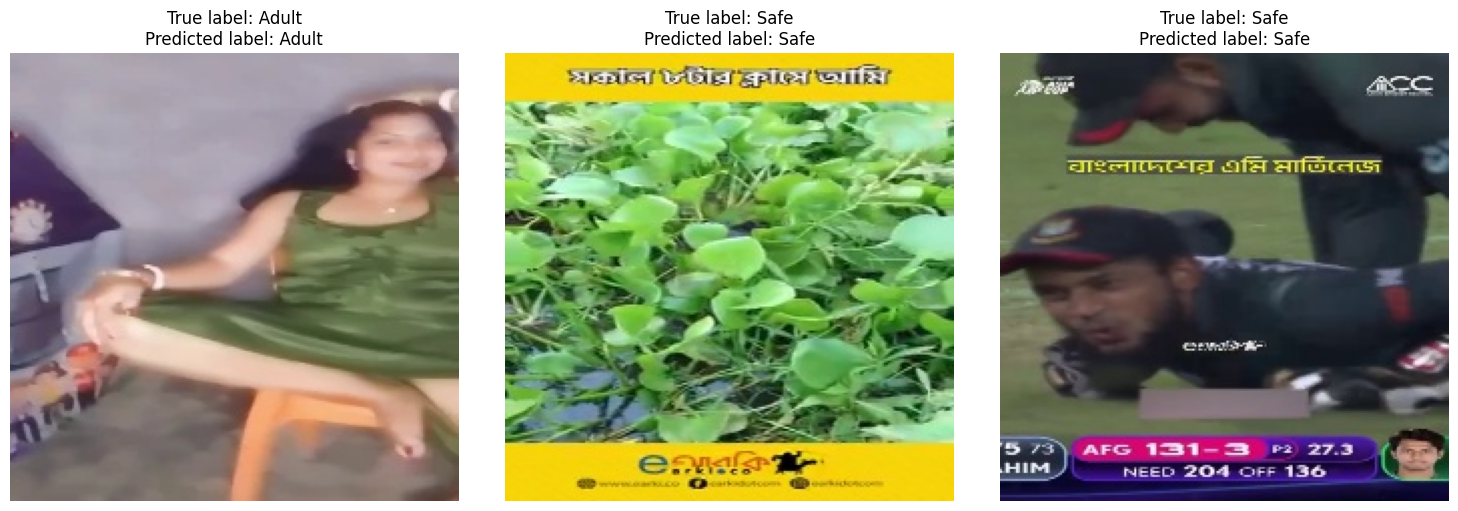

In [51]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load the saved model weights
model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()  # Set the model to evaluation mode

# Define the indices for the three images
indices = [0, 2, 10]

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Get the image and label from the dataset
    item = dataset[idx]
    image = item['image']
    true_label = item['labels']
    true_label = subcategories[true_label]

    # Transform the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = subcategories[predicted_label_idx.item()]

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [54]:
cm = confusion_matrix(y_true, y_pred)

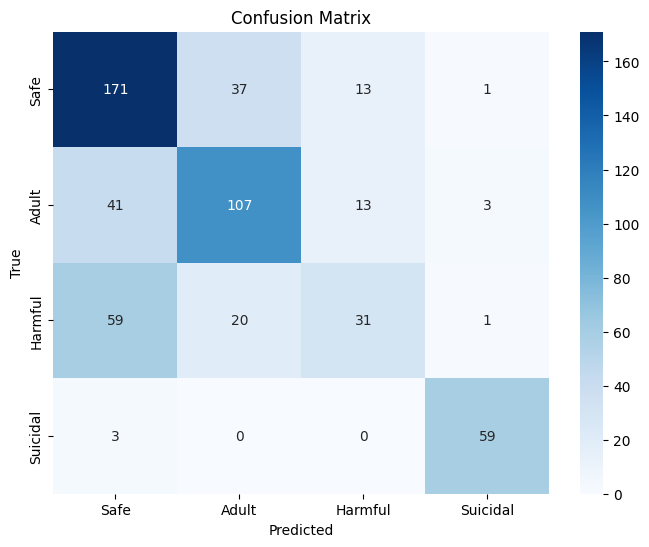

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(subcategories.values()),
            yticklabels=list(subcategories.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=list(subcategories.values())))

              precision    recall  f1-score   support

        Safe       0.62      0.77      0.69       222
       Adult       0.65      0.65      0.65       164
     Harmful       0.54      0.28      0.37       111
    Suicidal       0.92      0.95      0.94        62

    accuracy                           0.66       559
   macro avg       0.69      0.66      0.66       559
weighted avg       0.65      0.66      0.64       559

